# Project 4: <br>Using Computer Vision to Detect/Determine Pneumonia Using Lung X-Ray Images 

## Business Problem

Due to a shortage of staff and doctors through COVID-19, the St.Jude Children's Hospital wants to use A.I. to diagnose pneumonia through x-ray images of children's lungs. The goal of this project is to use convolution neural network for computer vision to detect pneumonia from x-ray images. 

## Model Training

In [1]:
import tensorflow as tf
tf.random.set_seed(609)
from tensorflow.keras import callbacks, models, layers, optimizers, regularizers

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import FalsePositives

import numpy as np
np.random.seed(817)
import os

from multiprocessing import Pool

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn import metrics
from sklearn.utils.class_weight import compute_class_weight

### Preprocessing

Because the size of the validation set provided was too small, the validation data set had to be split from the test set. To make sure that all data sets had the same batch size and target size, I created two objects to represent those numbers. When using the ImageDataGenerator, it was important to rescale each pixel as their values were represented in a RGB value that ranged from 0 to 255 so that all RGB values were represented between 0 and 1.

In [2]:
train_data_dir= 'data/train'
test_data_dir='data/test'

In [3]:
# When the batch size was reduced to 64, the results did not come out well
batch_batch=128 
target=(32,32)

In [4]:
train_set = ImageDataGenerator(rescale=1./255).flow_from_directory(
    train_data_dir, 
    target_size=target, 
    class_mode='binary',
    batch_size=batch_batch,
    seed=369)

test_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

test_set=test_generator.flow_from_directory(
    test_data_dir, 
    target_size=target,
    subset='training',
    class_mode='binary',
    batch_size=batch_batch, 
    seed=369)
val_set = test_generator.flow_from_directory(
    test_data_dir, 
    target_size=target,
    subset='validation',
    class_mode='binary',
    batch_size=batch_batch,
    seed=369)

Found 5216 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Found 124 images belonging to 2 classes.


In [5]:
def get_full_xy_from_gen(train_set):
    """Loops through an image data generator dataset
    and concatenates all batches of X and y samples.
    source:https://colab.research.google.com/drive/1HdM3ckzdL96BuGhAwnXwI0WllTGmG0uq#scrollTo=Pf_zrXuQFMVA
    written by James Irving (got permission from himself)
    """
    from tqdm import trange    
    Xs,ys= [],[]

    for i in trange(len(train_set)):
        X_,y_ = next(train_set)
        Xs.append(X_)
        ys.append(y_)
        
    X = np.concatenate(Xs,axis=0)
    y = np.concatenate(ys,axis=0)
    print(f"Final X data.shape: {X.shape}")
    print(f"Final y data.shape: {y.shape}")
    return X,y

In [6]:
X_train,y_train = get_full_xy_from_gen(train_set)
X_test,y_test = get_full_xy_from_gen(test_set)
X_val,y_val = get_full_xy_from_gen(val_set)

  0%|          | 0/4 [00:00<?, ?it/s]

Final X data.shape: (5216, 32, 32, 3)
Final y data.shape: (5216,)


  0%|          | 0/1 [00:00<?, ?it/s]

Final X data.shape: (500, 32, 32, 3)
Final y data.shape: (500,)


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]

Final X data.shape: (124, 32, 32, 3)
Final y data.shape: (124,)


In [6]:
pd.Series(train_set.labels).value_counts(1)

1    0.742906
0    0.257094
dtype: float64

In [7]:
## Get the array of weights for each unique class
weights= compute_class_weight(
           'balanced',
            np.unique(y_train),
            y_train)
weights

F:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0. 1.], y=[1. 1. 1. ... 1. 1. 0.] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


array([1.9448173 , 0.67303226])

In [8]:
## Turn the weights into a dict with the class name as the key
weights_dict = dict(zip( np.unique(y_train),weights))
weights_dict

{0.0: 1.9448173005219984, 1.0: 0.6730322580645162}

In [9]:
# Shows what classifications there are
train_set.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

## CNN (Convolution Neural Network)

For computer vision, using the convolution neural network is recommended. For each iteration, the goal is to decrease the number of layers used while achieving a high precision for detecting pneumonia.<br>
Each iteration will have two versions: one that monitors validation loss and another that monitors validation accuracy to stop the modeling process. 


### Iteration #1

In [9]:
# Calling tf.config.run_functions_eagerly(True) will make all invocations of tf.function run eagerly 
# instead of running as a traced graph function.
tf.config.run_functions_eagerly(True)

In [18]:
base=models.Sequential()

base.add(Conv2D(128, (3,3), activation='relu', input_shape=(target[0],target[1],3)))
base.add(Conv2D(128, (3,3), activation='relu'))
base.add(MaxPooling2D((2, 2)))

base.add(Conv2D(64, (3,3), activation='relu'))
base.add(Conv2D(64, (3,3), activation='relu'))
base.add(MaxPooling2D((2, 2),padding='same'))

base.add(Conv2D(64, (3,3), activation='relu',padding='same'))
base.add(Conv2D(64, (3,3), activation='relu',padding='same'))
base.add(MaxPooling2D((2, 2),padding='same'))

base.add(Conv2D(32, (3,3), activation='relu',padding='same'))
base.add(Conv2D(32, (3,3), activation='relu',padding='same'))
base.add(MaxPooling2D((2, 2),padding='same'))

base.add(Conv2D(32, (3,3), activation='relu',padding='same'))
base.add(Conv2D(32, (3,3), activation='relu',padding='same'))
base.add(MaxPooling2D((2, 2),padding='same'))

base.add(Flatten())
base.add(layers.Dense(128, activation ='relu'))
base.add(layers.Dense(64, activation ='relu'))
base.add(layers.Dense(1, activation ='sigmoid'))

base.compile(optimizer='adam', 
             loss='binary_crossentropy',
             metrics=['BinaryAccuracy'])
base.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 30, 30, 128)       3584      
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 28, 28, 128)       147584    
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 12, 12, 64)        73792     
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 10, 10, 64)        36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 5, 5, 64)         

In [58]:
# Function to show the model's loss and accuracy graph as well as the confusion matrix
def model_score(model, X_test, y_test):
    model_df=pd.DataFrame(model.history)
    
    loss_plt=model_df[[col for col in model_df.columns if 'loss' in col]].plot(marker='.')
    loss_plt.set(xlabel='Epoch',ylabel='MSE', title='Loss')
    plt.show()

    accuracy_plt=model_df[[col for col in model_df.columns if 'acc' in col]].plot(marker='.')
    accuracy_plt.set(xlabel='Epoch',ylabel='Accuracy', title='Accuracy')
    plt.show()
    
    test_pred = base.predict(X_test).flatten()
    test_pred=np.round(test_pred, 0)
    
    conf_matrix=metrics.confusion_matrix(y_test, test_pred, normalize='true')
    sns.heatmap(conf_matrix,annot= True, cmap='Blues', linewidths=.3)
    plt.xlabel('Predictions')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    
    print(metrics.classification_report(y_test, test_pred))

In [13]:
# Creating callbacks for different monitors. 
stop_early_loss = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
stop_early_acc_binary = EarlyStopping(monitor='val_binary_accuracy', patience=5, verbose=1, restore_best_weights=True)

reduce_lr_loss=ReduceLROnPlateau(monitor= 'val_loss', patience=3, factor=.2, min_lr=.001)
reduce_lr_acc_binary=ReduceLROnPlateau(monitor= 'val_binary_accuracy', patience=3, factor=.2, min_lr=.001)

callback_loss=[stop_early_loss, reduce_lr_loss]
callback_acc_binary = [stop_early_acc_binary, reduce_lr_acc_binary]

In [19]:
model1_loss=base.fit(X_train, y_train , epochs=30, batch_size=batch_batch, validation_data=(X_val, y_val), 
                  class_weight=weights_dict,  workers=-1, callbacks=callback_loss,
                  use_multiprocessing=True)

Epoch 1/30
41/41 [==============================] - 20s 498ms/step - loss: 0.6932 - binary_accuracy: 0.5282 - val_loss: 0.6810 - val_binary_accuracy: 0.8952
Epoch 2/30
41/41 [==============================] - 20s 490ms/step - loss: 0.4569 - binary_accuracy: 0.7636 - val_loss: 0.1952 - val_binary_accuracy: 0.9274
Epoch 3/30
41/41 [==============================] - 20s 497ms/step - loss: 0.2849 - binary_accuracy: 0.8731 - val_loss: 0.1832 - val_binary_accuracy: 0.9435
Epoch 4/30
41/41 [==============================] - 21s 500ms/step - loss: 0.1982 - binary_accuracy: 0.9181 - val_loss: 0.2942 - val_binary_accuracy: 0.8468
Epoch 5/30
41/41 [==============================] - 20s 498ms/step - loss: 0.1639 - binary_accuracy: 0.9358 - val_loss: 0.2988 - val_binary_accuracy: 0.8790
Epoch 6/30
41/41 [==============================] - 21s 502ms/step - loss: 0.1578 - binary_accuracy: 0.9358 - val_loss: 0.3635 - val_binary_accuracy: 0.8548
Epoch 7/30
41/41 [==============================] - 20s 48

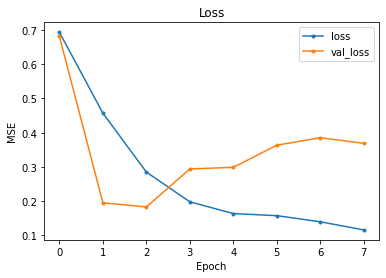

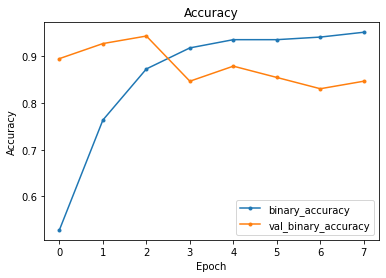

F:\Anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


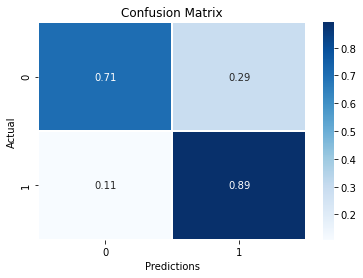

              precision    recall  f1-score   support

         0.0       0.80      0.71      0.75       188
         1.0       0.83      0.89      0.86       312

    accuracy                           0.82       500
   macro avg       0.82      0.80      0.81       500
weighted avg       0.82      0.82      0.82       500



In [20]:
model_score(model1_loss, X_test, y_test) #stop_early_acc adam

 comment on each model/version of what happend, what went wrong, and how to address/fix this issue

In [21]:
base=models.Sequential()

base.add(Conv2D(128, (3,3), activation='relu', input_shape=(target[0],target[1],3)))
base.add(Conv2D(128, (3,3), activation='relu'))
base.add(MaxPooling2D((2, 2)))

base.add(Conv2D(64, (3,3), activation='relu'))
base.add(Conv2D(64, (3,3), activation='relu'))
base.add(MaxPooling2D((2, 2),padding='same'))

base.add(Conv2D(64, (3,3), activation='relu',padding='same'))
base.add(Conv2D(64, (3,3), activation='relu',padding='same'))
base.add(MaxPooling2D((2, 2),padding='same'))

base.add(Conv2D(32, (3,3), activation='relu',padding='same'))
base.add(Conv2D(32, (3,3), activation='relu',padding='same'))
base.add(MaxPooling2D((2, 2),padding='same'))

base.add(Conv2D(32, (3,3), activation='relu',padding='same'))
base.add(Conv2D(32, (3,3), activation='relu',padding='same'))
base.add(MaxPooling2D((2, 2),padding='same'))

base.add(Flatten())
base.add(layers.Dense(128, activation ='relu'))
base.add(layers.Dense(64, activation ='relu'))
base.add(layers.Dense(1, activation ='sigmoid'))

base.compile(optimizer='adam', 
             loss='binary_crossentropy',
             metrics=['BinaryAccuracy'])

In [22]:
model1_acc=base.fit(X_train, y_train , epochs=30, batch_size=batch_batch, validation_data=(X_val, y_val), 
                  class_weight=weights_dict,  workers=-1, callbacks=callback_acc_binary,
                  use_multiprocessing=True)

Epoch 1/30
41/41 [==============================] - 20s 494ms/step - loss: 0.6878 - binary_accuracy: 0.6350 - val_loss: 0.5034 - val_binary_accuracy: 0.9355
Epoch 2/30
41/41 [==============================] - 20s 487ms/step - loss: 0.3585 - binary_accuracy: 0.8413 - val_loss: 0.3787 - val_binary_accuracy: 0.8065
Epoch 3/30
41/41 [==============================] - 20s 488ms/step - loss: 0.2218 - binary_accuracy: 0.9109 - val_loss: 0.3030 - val_binary_accuracy: 0.8468
Epoch 4/30
41/41 [==============================] - 20s 487ms/step - loss: 0.1776 - binary_accuracy: 0.9248 - val_loss: 0.1841 - val_binary_accuracy: 0.9113
Epoch 5/30
41/41 [==============================] - 21s 505ms/step - loss: 0.1520 - binary_accuracy: 0.9375 - val_loss: 0.4156 - val_binary_accuracy: 0.8226
Epoch 6/30
41/41 [==============================] - 20s 499ms/step - loss: 0.1282 - binary_accuracy: 0.9498 - val_loss: 0.1488 - val_binary_accuracy: 0.9597
Epoch 7/30
41/41 [==============================] - 20s 49

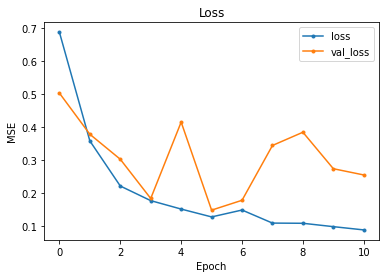

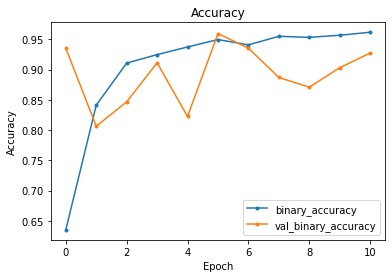

F:\Anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


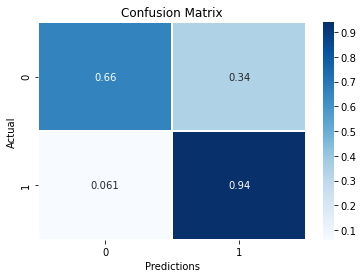

              precision    recall  f1-score   support

         0.0       0.87      0.66      0.75       188
         1.0       0.82      0.94      0.88       312

    accuracy                           0.83       500
   macro avg       0.84      0.80      0.81       500
weighted avg       0.84      0.83      0.83       500



In [24]:
model_score(model1_acc, X_test, y_test) #stop_early_loss AdaMax

While recall rate seems to be doing decent when predicting pneumonia in patients, it mostly predicts everyone to have pneumonia. 
talk about what i said in the presentation

### Iteration #2


In [25]:
iter_2=models.Sequential()

iter_2.add(Conv2D(128, (3,3), activation='relu', input_shape=(target[0],target[1],3)))
iter_2.add(Conv2D(128, (3,3), activation='relu'))
iter_2.add(MaxPooling2D((2, 2)))

iter_2.add(Conv2D(64, (3,3), activation='relu',padding='same'))
iter_2.add(Conv2D(64, (3,3), activation='relu',padding='same'))
iter_2.add(MaxPooling2D((2, 2),padding='same'))

iter_2.add(Conv2D(64, (3,3), activation='relu',padding='same'))
iter_2.add(Conv2D(64, (3,3), activation='relu',padding='same'))
iter_2.add(MaxPooling2D((2, 2),padding='same'))

iter_2.add(Conv2D(32, (3,3), activation='relu',padding='same'))
iter_2.add(Conv2D(32, (3,3), activation='relu',padding='same'))
iter_2.add(MaxPooling2D((2, 2),padding='same'))

iter_2.add(Flatten())
iter_2.add(layers.Dense(128, activation ='relu'))
iter_2.add(layers.Dense(64, activation ='relu'))
iter_2.add(layers.Dense(1, activation ='sigmoid'))

iter_2.compile(optimizer='adam', 
             loss='binary_crossentropy',
             metrics=['BinaryAccuracy'])

In [26]:
iter_2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 30, 30, 128)       3584      
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 28, 28, 128)       147584    
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 14, 14, 64)        73792     
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 7, 7, 64)         

In [27]:
model2_loss=iter_2.fit(X_train, y_train , epochs=30, batch_size=batch_batch, validation_data=(X_val, y_val), 
                  class_weight=weights_dict,  workers=-1, callbacks=callback_loss,
                  use_multiprocessing=True)

Epoch 1/30
41/41 [==============================] - 22s 531ms/step - loss: 0.6379 - binary_accuracy: 0.5895 - val_loss: 0.2150 - val_binary_accuracy: 0.9274
Epoch 2/30
41/41 [==============================] - 22s 526ms/step - loss: 0.2993 - binary_accuracy: 0.8681 - val_loss: 0.2267 - val_binary_accuracy: 0.8710
Epoch 3/30
41/41 [==============================] - 23s 551ms/step - loss: 0.1821 - binary_accuracy: 0.9268 - val_loss: 0.3258 - val_binary_accuracy: 0.8065
Epoch 4/30
41/41 [==============================] - 22s 549ms/step - loss: 0.1524 - binary_accuracy: 0.9350 - val_loss: 0.3578 - val_binary_accuracy: 0.8468
Epoch 5/30
41/41 [==============================] - 22s 540ms/step - loss: 0.1174 - binary_accuracy: 0.9536 - val_loss: 0.3736 - val_binary_accuracy: 0.8306
Epoch 6/30
41/41 [==============================] - 23s 556ms/step - loss: 0.1076 - binary_accuracy: 0.9586 - val_loss: 0.5402 - val_binary_accuracy: 0.7903
Restoring model weights from the end of the best epoch.
Ep

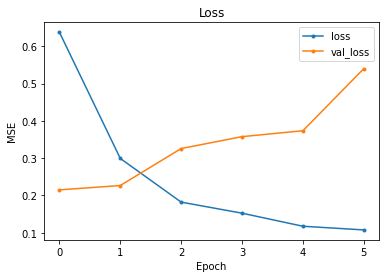

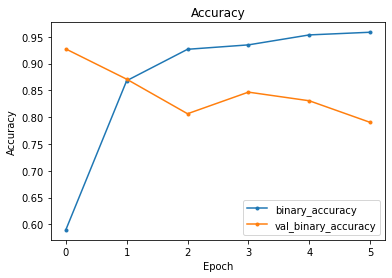

F:\Anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


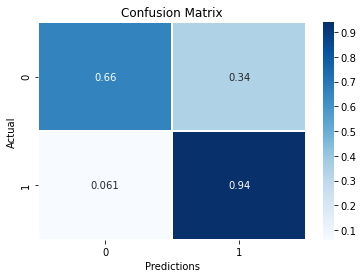

              precision    recall  f1-score   support

         0.0       0.87      0.66      0.75       188
         1.0       0.82      0.94      0.88       312

    accuracy                           0.83       500
   macro avg       0.84      0.80      0.81       500
weighted avg       0.84      0.83      0.83       500



In [28]:
model_score(model2_loss, X_test, y_test)

In [29]:
iter_2=models.Sequential()

iter_2.add(Conv2D(128, (3,3), activation='relu', input_shape=(target[0],target[1],3)))
iter_2.add(Conv2D(128, (3,3), activation='relu'))
iter_2.add(MaxPooling2D((2, 2)))

iter_2.add(Conv2D(64, (3,3), activation='relu',padding='same'))
iter_2.add(Conv2D(64, (3,3), activation='relu',padding='same'))
iter_2.add(MaxPooling2D((2, 2),padding='same'))

iter_2.add(Conv2D(64, (3,3), activation='relu',padding='same'))
iter_2.add(Conv2D(64, (3,3), activation='relu',padding='same'))
iter_2.add(MaxPooling2D((2, 2),padding='same'))

iter_2.add(Conv2D(32, (3,3), activation='relu',padding='same'))
iter_2.add(Conv2D(32, (3,3), activation='relu',padding='same'))
iter_2.add(MaxPooling2D((2, 2),padding='same'))

iter_2.add(Flatten())
iter_2.add(layers.Dense(128, activation ='relu'))
iter_2.add(layers.Dense(64, activation ='relu'))
iter_2.add(layers.Dense(1, activation ='sigmoid'))

iter_2.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['BinaryAccuracy'])

In [30]:
model2_acc=iter_2.fit(X_train, y_train , epochs=30, batch_size=batch_batch, validation_data=(X_val, y_val), 
                  class_weight=weights_dict,  workers=-1, callbacks=callback_acc_binary,
                  use_multiprocessing=True)

Epoch 1/30
41/41 [==============================] - 22s 537ms/step - loss: 0.6552 - binary_accuracy: 0.5966 - val_loss: 0.1818 - val_binary_accuracy: 0.9355
Epoch 2/30
41/41 [==============================] - 24s 588ms/step - loss: 0.3414 - binary_accuracy: 0.8449 - val_loss: 0.3098 - val_binary_accuracy: 0.8226
Epoch 3/30
41/41 [==============================] - 25s 604ms/step - loss: 0.1799 - binary_accuracy: 0.9245 - val_loss: 0.6216 - val_binary_accuracy: 0.7258
Epoch 4/30
41/41 [==============================] - 22s 543ms/step - loss: 0.1410 - binary_accuracy: 0.9429 - val_loss: 0.3153 - val_binary_accuracy: 0.8468
Epoch 5/30
41/41 [==============================] - 22s 534ms/step - loss: 0.1270 - binary_accuracy: 0.9498 - val_loss: 0.3286 - val_binary_accuracy: 0.8468
Epoch 6/30
41/41 [==============================] - 22s 536ms/step - loss: 0.1265 - binary_accuracy: 0.9503 - val_loss: 0.2695 - val_binary_accuracy: 0.8790
Restoring model weights from the end of the best epoch.
Ep

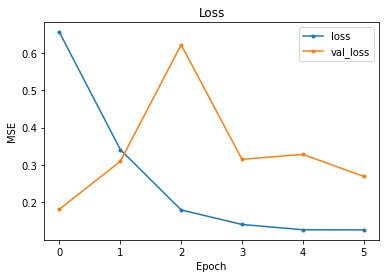

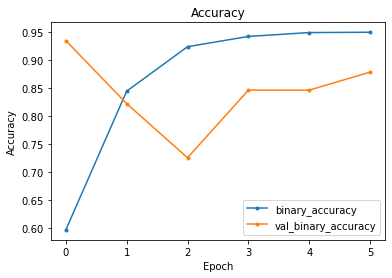

F:\Anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


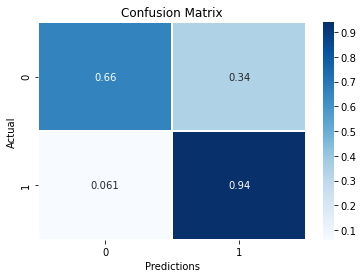

              precision    recall  f1-score   support

         0.0       0.87      0.66      0.75       188
         1.0       0.82      0.94      0.88       312

    accuracy                           0.83       500
   macro avg       0.84      0.80      0.81       500
weighted avg       0.84      0.83      0.83       500



In [31]:
model_score(model2_acc, X_test, y_test)

### Iteration #3

In [61]:
iter3=models.Sequential()

iter3.add(Conv2D(64, (3,3), activation='relu', input_shape=(target[0],target[1],3)))
iter3.add(MaxPooling2D((2, 2)))

iter3.add(Conv2D(32, (3,3), activation='relu'))
iter3.add(Conv2D(32, (3,3), activation='relu'))
iter3.add(MaxPooling2D((2, 2)))

iter3.add(Conv2D(32, (3,3), activation='relu'))
iter3.add(MaxPooling2D((2, 2)))

iter3.add(Flatten())
iter3.add(layers.Dense(64, activation ='relu'))
iter3.add(layers.Dense(1, activation ='sigmoid'))

iter3.compile(optimizer='adam', 
             loss='binary_crossentropy',
             metrics=['BinaryAccuracy'])

In [62]:
iter3.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_92 (Conv2D)           (None, 30, 30, 64)        1792      
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_93 (Conv2D)           (None, 13, 13, 32)        18464     
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 11, 11, 32)        9248      
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 5, 5, 32)          0         
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 3, 3, 32)          9248      
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 1, 1, 32)        

In [63]:
model3_loss=iter3.fit(X_train, y_train , epochs=30, batch_size=batch_batch, validation_data=(X_val, y_val), 
                  class_weight=weights_dict,  workers=-1, callbacks=callback_loss,
                  use_multiprocessing=True)

Epoch 1/30
41/41 [==============================] - 4s 104ms/step - loss: 0.6864 - binary_accuracy: 0.5383 - val_loss: 0.6222 - val_binary_accuracy: 0.6935
Epoch 2/30
41/41 [==============================] - 4s 104ms/step - loss: 0.4915 - binary_accuracy: 0.7722 - val_loss: 0.2782 - val_binary_accuracy: 0.8629
Epoch 3/30
41/41 [==============================] - 4s 101ms/step - loss: 0.3228 - binary_accuracy: 0.8531 - val_loss: 0.2292 - val_binary_accuracy: 0.9032
Epoch 4/30
41/41 [==============================] - 4s 102ms/step - loss: 0.2649 - binary_accuracy: 0.8865 - val_loss: 0.1962 - val_binary_accuracy: 0.9435
Epoch 5/30
41/41 [==============================] - 4s 101ms/step - loss: 0.2239 - binary_accuracy: 0.9091 - val_loss: 0.2064 - val_binary_accuracy: 0.9274
Epoch 6/30
41/41 [==============================] - 4s 101ms/step - loss: 0.2031 - binary_accuracy: 0.9164 - val_loss: 0.1946 - val_binary_accuracy: 0.9355
Epoch 7/30
41/41 [==============================] - 4s 101ms/ste

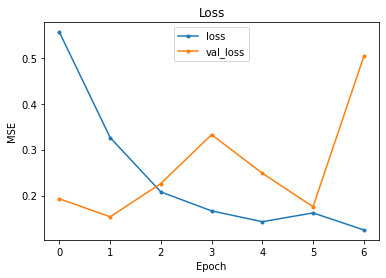

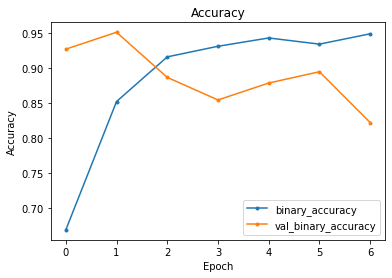

F:\Anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


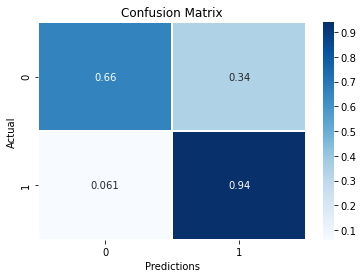

              precision    recall  f1-score   support

         0.0       0.87      0.66      0.75       188
         1.0       0.82      0.94      0.88       312

    accuracy                           0.83       500
   macro avg       0.84      0.80      0.81       500
weighted avg       0.84      0.83      0.83       500



In [53]:
model_score(model3_loss, X_test, y_test) #after change

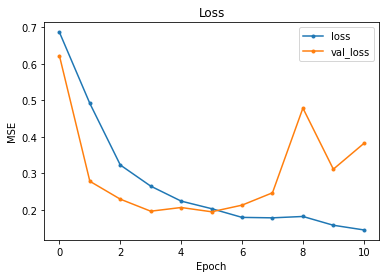

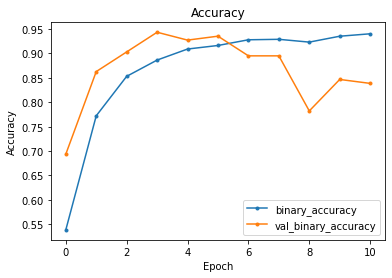

F:\Anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


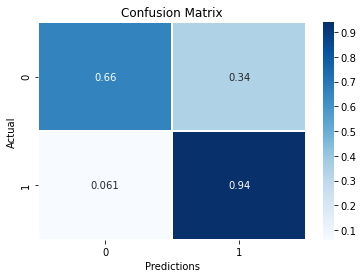

              precision    recall  f1-score   support

         0.0       0.87      0.66      0.75       188
         1.0       0.82      0.94      0.88       312

    accuracy                           0.83       500
   macro avg       0.84      0.80      0.81       500
weighted avg       0.84      0.83      0.83       500



In [64]:
model_score(model3_loss, X_test, y_test) # before change

In [36]:
iter3=models.Sequential()

iter3.add(Conv2D(64, (3,3), activation='relu', input_shape=(target[0],target[1],3)))
iter3.add(MaxPooling2D((2, 2)))

iter3.add(Conv2D(32, (3,3), activation='relu'))
iter3.add(Conv2D(32, (3,3), activation='relu'))
iter3.add(MaxPooling2D((2, 2)))

iter3.add(Conv2D(32, (3,3), activation='relu'))
iter3.add(MaxPooling2D((2, 2)))

iter3.add(Flatten())
iter3.add(layers.Dense(64, activation ='relu'))
iter3.add(layers.Dense(1, activation ='sigmoid'))

iter3.compile(optimizer='adam', 
             loss='binary_crossentropy',
             metrics=['BinaryAccuracy'])

In [56]:
model3_acc=iter3.fit(X_train, y_train , epochs=30, batch_size=batch_batch, validation_data=(X_val, y_val), 
                  class_weight=weights_dict,  workers=-1, callbacks=callback_acc_binary,
                  use_multiprocessing=True)

Epoch 1/30
41/41 [==============================] - 5s 130ms/step - loss: 0.5590 - binary_accuracy: 0.7743 - val_loss: 0.2205 - val_binary_accuracy: 0.9113
Epoch 2/30
41/41 [==============================] - 5s 133ms/step - loss: 0.3044 - binary_accuracy: 0.8585 - val_loss: 0.1904 - val_binary_accuracy: 0.9355
Epoch 3/30
41/41 [==============================] - 5s 131ms/step - loss: 0.2135 - binary_accuracy: 0.9109 - val_loss: 0.2335 - val_binary_accuracy: 0.8871
Epoch 4/30
41/41 [==============================] - 5s 129ms/step - loss: 0.1779 - binary_accuracy: 0.9247 - val_loss: 0.1533 - val_binary_accuracy: 0.9355
Epoch 5/30
41/41 [==============================] - 5s 127ms/step - loss: 0.1474 - binary_accuracy: 0.9358 - val_loss: 0.2730 - val_binary_accuracy: 0.8790
Epoch 6/30
41/41 [==============================] - 5s 128ms/step - loss: 0.1445 - binary_accuracy: 0.9404 - val_loss: 0.3435 - val_binary_accuracy: 0.8145
Epoch 7/30
41/41 [==============================] - 5s 127ms/ste

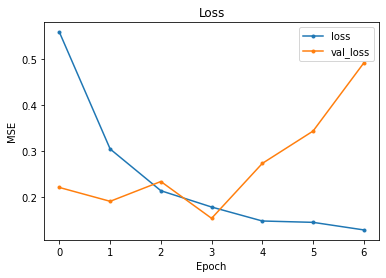

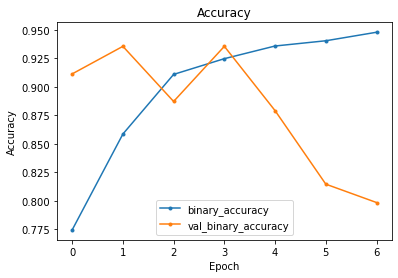

F:\Anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


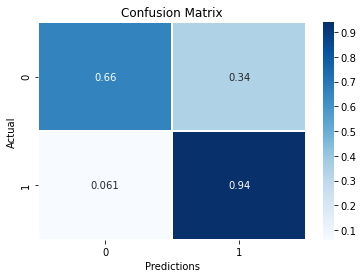

              precision    recall  f1-score   support

         0.0       0.87      0.66      0.75       188
         1.0       0.82      0.94      0.88       312

    accuracy                           0.83       500
   macro avg       0.84      0.80      0.81       500
weighted avg       0.84      0.83      0.83       500



In [59]:
model_score(model3_acc, X_test, y_test)

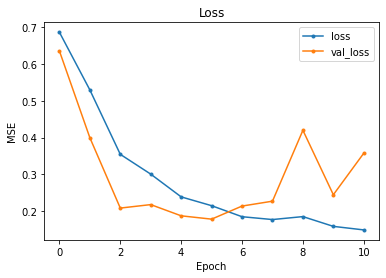

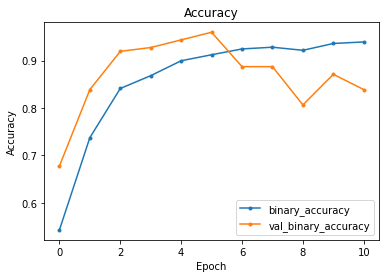

F:\Anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


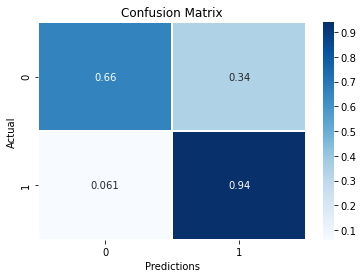

              precision    recall  f1-score   support

         0.0       0.87      0.66      0.75       188
         1.0       0.82      0.94      0.88       312

    accuracy                           0.83       500
   macro avg       0.84      0.80      0.81       500
weighted avg       0.84      0.83      0.83       500



In [38]:
model_score(model3_acc, X_test, y_test) #before change

### Iteration #4

Removed much of the layers and maxpooling2d, changed metrics to binary accuracy 

In [39]:
iter4=models.Sequential()

iter4.add(Conv2D(64, (3,3), activation='relu', input_shape=(target[0],target[1],3)))
iter4.add(MaxPooling2D((2, 2)))

iter4.add(Conv2D(32, (3,3), activation='relu'))
iter4.add(MaxPooling2D((2, 2)))

iter4.add(Flatten())
iter4.add(layers.Dense(64, activation ='relu'))
iter4.add(layers.Dense(1, activation ='sigmoid'))

iter4.compile(optimizer='adam', 
             loss='binary_crossentropy',
             metrics=['BinaryAccuracy'])

In [40]:
model4_loss=iter4.fit(X_train, y_train , epochs=30, batch_size=batch_batch, validation_data=(X_val, y_val), 
                  class_weight=weights_dict,  workers=-1, callbacks=callback_loss,
                  use_multiprocessing=True)

Epoch 1/30
41/41 [==============================] - 4s 92ms/step - loss: 0.5293 - binary_accuracy: 0.7377 - val_loss: 0.2738 - val_binary_accuracy: 0.9274
Epoch 2/30
41/41 [==============================] - 4s 91ms/step - loss: 0.2508 - binary_accuracy: 0.9003 - val_loss: 0.2269 - val_binary_accuracy: 0.9032
Epoch 3/30
41/41 [==============================] - 4s 93ms/step - loss: 0.1721 - binary_accuracy: 0.9296 - val_loss: 0.2703 - val_binary_accuracy: 0.8871
Epoch 4/30
41/41 [==============================] - 4s 90ms/step - loss: 0.1487 - binary_accuracy: 0.9413 - val_loss: 0.5284 - val_binary_accuracy: 0.7661
Epoch 5/30
41/41 [==============================] - 4s 92ms/step - loss: 0.1239 - binary_accuracy: 0.9513 - val_loss: 0.6095 - val_binary_accuracy: 0.7581
Epoch 6/30
41/41 [==============================] - 4s 92ms/step - loss: 0.1104 - binary_accuracy: 0.9571 - val_loss: 0.5258 - val_binary_accuracy: 0.7903
Epoch 7/30
41/41 [==============================] - 4s 93ms/step - los

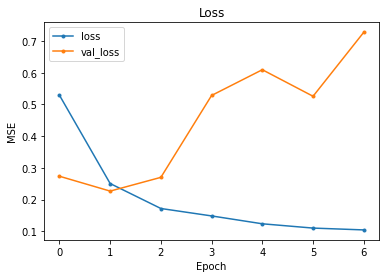

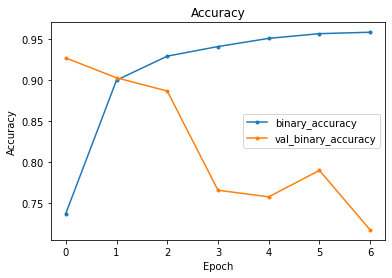

F:\Anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


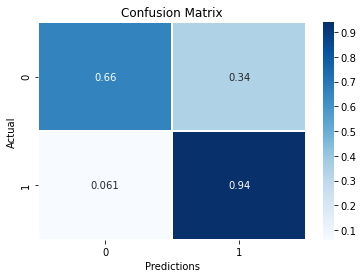

              precision    recall  f1-score   support

         0.0       0.87      0.66      0.75       188
         1.0       0.82      0.94      0.88       312

    accuracy                           0.83       500
   macro avg       0.84      0.80      0.81       500
weighted avg       0.84      0.83      0.83       500



In [41]:
model_score(model4_loss, X_test, y_test)

In [42]:
iter4=models.Sequential()

iter4.add(Conv2D(64, (3,3), activation='relu', input_shape=(target[0],target[1],3)))
iter4.add(MaxPooling2D((2, 2)))

iter4.add(Conv2D(32, (3,3), activation='relu'))
iter4.add(MaxPooling2D((2, 2)))

iter4.add(Flatten())
iter4.add(layers.Dense(64, activation ='relu'))
iter4.add(layers.Dense(1, activation ='sigmoid'))

iter4.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['BinaryAccuracy'])

In [43]:
model4_acc=iter4.fit(X_train, y_train , epochs=30, batch_size=batch_batch, validation_data=(X_val, y_val), 
                  class_weight=weights_dict,  workers=-1, callbacks=callback_acc_binary,
                  use_multiprocessing=True)

Epoch 1/30
41/41 [==============================] - 4s 91ms/step - loss: 0.5551 - binary_accuracy: 0.6954 - val_loss: 0.3402 - val_binary_accuracy: 0.8952
Epoch 2/30
41/41 [==============================] - 4s 92ms/step - loss: 0.2631 - binary_accuracy: 0.8867 - val_loss: 0.2841 - val_binary_accuracy: 0.8468
Epoch 3/30
41/41 [==============================] - 4s 90ms/step - loss: 0.1773 - binary_accuracy: 0.9314 - val_loss: 0.3155 - val_binary_accuracy: 0.8387
Epoch 4/30
41/41 [==============================] - 4s 91ms/step - loss: 0.1556 - binary_accuracy: 0.9383 - val_loss: 0.5189 - val_binary_accuracy: 0.7661
Epoch 5/30
41/41 [==============================] - 4s 91ms/step - loss: 0.1292 - binary_accuracy: 0.9494 - val_loss: 0.6073 - val_binary_accuracy: 0.7419
Epoch 6/30
41/41 [==============================] - 4s 94ms/step - loss: 0.1140 - binary_accuracy: 0.9526 - val_loss: 0.5698 - val_binary_accuracy: 0.7742
Restoring model weights from the end of the best epoch.
Epoch 00006: e

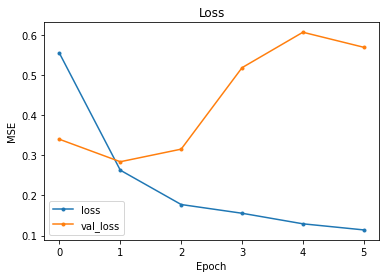

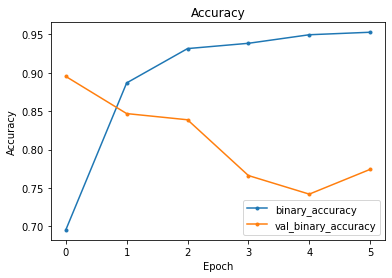

F:\Anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


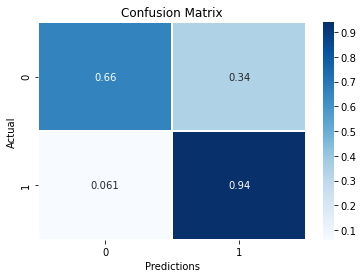

              precision    recall  f1-score   support

         0.0       0.87      0.66      0.75       188
         1.0       0.82      0.94      0.88       312

    accuracy                           0.83       500
   macro avg       0.84      0.80      0.81       500
weighted avg       0.84      0.83      0.83       500



In [44]:
model_score(model4_acc, X_test, y_test)#using top one

## Conclusion

### Model Recommendation

For each iteration of the models, there were two versions; one that looked at the validation accuracy and one that looked at validation accuracy as the main determinant in setting the stopping point for the neural network.<br>
I would recommend using the model from the 3rd iteration that uses validation accuracy  as the stopping metric. For all of the iterations, the recall rate for the true positives were similar;however, when comparing the histograms showing the training and validation scores for each epochs had the best shape, meaning that the neural network was able to learn the best from this model.

add medical recommendations (why false positives are bad)


### Future Work
For future work, I would like to improve the model's prediction on false positives. While it was very apt in diagnosing pneumonia for patients with pneumonia, it was as much likely to diagnose pneumonia to those who did not have the disease. Possible solutions may be:
 - Format/align the pictures to show just the thorax region to remove possible mis-detections
 - Distinguish sections such as the heart to remove possible mis-detections
 - Separate images of bacterial pneumonia and viral pneumonia for training for ease of diagnosis since they require different treatments. 
 
### Final Thoughts
Overall, the project was as challenging as it was insightful. After visiting an A.I. expo and seeing how computer vision was being used to diagnose cancer and how the A.I. that they had created were finding previously unknown indications that could lead to an early diagnosis of breast cancer. The year before this, the doctors had found a tumor-like tissue in her uterus during an annual check up. Fortunately it turned out to be a benign form, but we were worried that she could develop breast cancer as uterine tumors could lead to or were early signs of breast cancer. Because of this previous incident, the use of A.I. in diagnosing cancer spoke to me in a different way, and I became much interested in general A.I. and the use of A.I. in the medical field. Though this project is miles behind compared to what I had seen in the expo, it was meaningful nonetheless.